#Import

In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
pd.set_option('display.max_colwidth', 500)
import warnings
warnings.filterwarnings('ignore')
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

##Get the Data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/recommendation_df.csv")
df.isna().sum()
# df.head(1)

Name                  0
url                   0
Ingredients           0
Category              0
Label                 0
Countries             0
nutri_score        4663
nutri_grade        4663
nova_grade         5928
Cholesterol           0
Fat                   0
Sodium                0
Sugars                0
Carbohydrates         0
Protein               0
Saturated fat         0
Fiber                 0
Trans fat             0
Energy_kcal           0
additives             0
Additives_count       0
dtype: int64

In [ ]:
# Load the models
nova_rfc = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_rfc_11.pkl")
nutri_rfr = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/best_nutri_rfr_old1.pkl")

#Pre-processing

##Predict & Classify Missing Targets

This dataset contains products with missing targets, which will be filled-in using the previously built Random Forest pipeline to increase the number of products being recommended

After Filling in missing values, the remaining nulls in other features will be dropped. 

###Make Classification & Predictions

**Nova-grade**

In [ ]:
# subset the classification dataset with missing Nova-grade
df_nova =  df.drop(columns= ["Name","url","Ingredients", "Category", "Label","Countries", "nutri_grade", "nutri_score","additives"])[df.nova_grade.isna()]

#Split the features and target for Classification
X_nova = df_nova.drop(columns= ["nova_grade"])
y_nova = df_nova.nova_grade
X_nova.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5928 entries, 4 to 220393
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cholesterol      5928 non-null   float64
 1   Fat              5928 non-null   float64
 2   Sodium           5928 non-null   float64
 3   Sugars           5928 non-null   float64
 4   Carbohydrates    5928 non-null   float64
 5   Protein          5928 non-null   float64
 6   Saturated fat    5928 non-null   float64
 7   Fiber            5928 non-null   float64
 8   Trans fat        5928 non-null   float64
 9   Energy_kcal      5928 non-null   float64
 10  Additives_count  5928 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 555.8 KB


In [ ]:
# Classify Nova-grade
nova_pred = nova_rfc.predict(X_nova)
y_nova = nova_pred
len(y_nova)

5928

**Nutri-score**

In [ ]:
df_nutri = df.drop(columns= ["Name","url","Ingredients", "Category","Countries", "Label", "nutri_grade", "nova_grade","additives"])[df.nutri_score.isna()]

#Split the features and target for Prediction
X_nutri = df_nutri.drop(columns= ["nutri_score"])
y_nutri = df_nutri.nutri_score

X_nutri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4663 entries, 115 to 220388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cholesterol      4663 non-null   float64
 1   Fat              4663 non-null   float64
 2   Sodium           4663 non-null   float64
 3   Sugars           4663 non-null   float64
 4   Carbohydrates    4663 non-null   float64
 5   Protein          4663 non-null   float64
 6   Saturated fat    4663 non-null   float64
 7   Fiber            4663 non-null   float64
 8   Trans fat        4663 non-null   float64
 9   Energy_kcal      4663 non-null   float64
 10  Additives_count  4663 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 437.2 KB


In [ ]:
# Predict Nutri_score
nutri_pred = nutri_rfr.predict(X_nutri)
y_nutri = nutri_pred
len(y_nutri)

4663

####Filling in

In [ ]:
# Fill Nova in main df
df.loc[df.nova_grade.isna(), "nova_grade"] = y_nova
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220396 entries, 0 to 220395
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             220396 non-null  object 
 1   url              220396 non-null  object 
 2   Ingredients      220396 non-null  object 
 3   Category         220396 non-null  object 
 4   Label            220396 non-null  object 
 5   Countries        220396 non-null  object 
 6   nutri_score      215733 non-null  float64
 7   nutri_grade      215733 non-null  object 
 8   nova_grade       220396 non-null  float64
 9   Cholesterol      220396 non-null  float64
 10  Fat              220396 non-null  float64
 11  Sodium           220396 non-null  float64
 12  Sugars           220396 non-null  float64
 13  Carbohydrates    220396 non-null  float64
 14  Protein          220396 non-null  float64
 15  Saturated fat    220396 non-null  float64
 16  Fiber            220396 non-null  floa

Now all products have been labeled with its corresponding Nova-grades. 

There are some products left with missing Nutri labels to be filled-in

In [ ]:
def nutri_grade_convert(nutri_score):
  """ 
  Function to convert Nutri-score to Nutri-grade
  """

  if nutri_score >= -15 and nutri_score <= -1:
    nutri_grade = "a"
  elif nutri_score >=0 and nutri_score <=2:
    nutri_grade = "b"
  elif nutri_score >=3 and nutri_score <= 10:
    nutri_grade = "c"
  elif nutri_score >=11 and nutri_score <=18:
    nutri_grade = "d"
  else:
    nutri_grade = "e"

  return nutri_grade

In [ ]:
# Fill missing Nutri_snutri in main_df
df.loc[df.nutri_score.isna(), "nutri_score"] = y_nutri
df.loc[df.nutri_grade.isna(), "nutri_grade"] = df.loc[df.nutri_grade.isna(), "nutri_grade"].apply(nutri_grade_convert)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220396 entries, 0 to 220395
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             220396 non-null  object 
 1   url              220396 non-null  object 
 2   Ingredients      220396 non-null  object 
 3   Category         220396 non-null  object 
 4   Label            220396 non-null  object 
 5   Countries        220396 non-null  object 
 6   nutri_score      220396 non-null  float64
 7   nutri_grade      220396 non-null  object 
 8   nova_grade       220396 non-null  float64
 9   Cholesterol      220396 non-null  float64
 10  Fat              220396 non-null  float64
 11  Sodium           220396 non-null  float64
 12  Sugars           220396 non-null  float64
 13  Carbohydrates    220396 non-null  float64
 14  Protein          220396 non-null  float64
 15  Saturated fat    220396 non-null  float64
 16  Fiber            220396 non-null  floa

**Comment:** All products have labels. Let's use this data to prepare for Recommendation

But first, let's drop the nutrients columns since they are not necessary for Recommendation

In [ ]:
data = df.drop(columns= ["Cholesterol","Fat","Sodium","Sugars","Carbohydrates","Protein","Saturated fat","Fiber","Trans fat","Energy_kcal","additives","Additives_count", "nutri_score"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220396 entries, 0 to 220395
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         220396 non-null  object 
 1   url          220396 non-null  object 
 2   Ingredients  220396 non-null  object 
 3   Category     220396 non-null  object 
 4   Label        220396 non-null  object 
 5   Countries    220396 non-null  object 
 6   nutri_grade  220396 non-null  object 
 7   nova_grade   220396 non-null  float64
dtypes: float64(1), object(7)
memory usage: 13.5+ MB


##Preprocess Category

###Change Category

Similarly, let's group the products that fall into the same Categories together and join multiple words in a name by "-"

In [ ]:
# def change_category(data):
#   data.Category = data.Category.str.lower()
  
#   data.loc[data.Category.str.contains(r"(plant-based foods|frozen foods|frozen vegetables|frozen blueberries)", regex=True), "Category"] = "plant-based-foods"
#   data.loc[data.Category.str.contains("cereals", regex=True), "Category"] = "cereals"
#   data.loc[data.Category.str.contains(r"(fruits and vegetables based foods|fruits based foods)", regex=True), "Category"] = "plant-based-foods"
#   data.loc[data.Category.str.contains(r"(snacks|biscuits|cakes|chocolate candies|corn chips)", regex=True), "Category"] = "snacks"
#   data.loc[data.Category.str.contains(r"(milk|milks)", regex=True), "Category"] = "milk"
#   data.loc[data.Category.str.contains(r"(cheese|cheddar)", regex=True), "Category"] = "cheese"
#   data.loc[data.Category.str.contains(r"(pizza|pizzas)", regex=True), "Category"] = "pizza"
#   data.loc[data.Category.str.contains(r"(meat|beef|chicken|fish|turkeys|bacon|ham)", regex=True), "Category"] = "meat"
#   data.loc[data.Category.str.contains(r"(pizza|soups|canned soups|sauces)", regex=True), "Category"] = "meals"
#   data.loc[data.Category.str.contains(r"frozen desserts", regex=True), "Category"] = "desserts"

In [ ]:
data.loc[(data.Name.str.contains(r"plant-based|vegetarian|meatless|tofu|vegetarian sausages", flags=re.IGNORECASE, regex=True)) & (data.Category.str.contains(r"Meat", flags=re.IGNORECASE, regex=True)), "Category"] = "Plant-protein"
data.loc[data.Name.str.contains(r"Vegan egg", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"(plant-based foods|frozen foods|frozen vegetables|frozen blueberries)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(fruits and vegetables based foods|fruits based foods)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(coconut milk|Soy milks|Plant milks|Almond milks|Soymilks|Cereal milks|Rice milks|Vanilla soy milks|Almon milk yogurts)", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"meat|turkey|chicken|lamb|breast|beef|poultry|lobster|pork|bacon|ham", flags=re.IGNORECASE, regex=True), "Category"] = "Meat"
data.loc[data.Category.str.contains(r"(seaf|fish)", flags=re.IGNORECASE, regex=True), "Category"] = "Seafood"
data.loc[(data.Category.str.contains(r"(Plant milks)", flags=re.IGNORECASE, regex=True)), "Label"] = "Vegan"
data.loc[data.Name.str.contains(r"(cheese|parmesan|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(dairy|milk|cheese|yogurt|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Category"] = "Dairy"
data.loc[data.Category.str.contains(r"eggs", flags=re.IGNORECASE, regex=True), "Category"] = "Eggs"
data.loc[data.Category.str.contains(r"grain|rices|oats|chia|cereal", flags=re.IGNORECASE, regex=True), "Category"] = "Grains"
data.loc[data.Category.str.contains(r"\Wnuts|Chestnuts|walnuts|peanuts|hazelnuts|cashews|beans|peas|edamame|quinoa", flags=re.IGNORECASE, regex=True), "Category"] = "Nuts"
data.loc[data.Category.str.contains(r"Nuts", regex=True), "Category"] = "Legumes"
# data.loc[data.Category.str.contains(r"vegetables|salads|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Category.str.contains(r"vegetables|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(fruits|apples|plums|oranges)", flags=re.IGNORECASE , regex=True), "Category"] = "Fruits"
data.loc[data.Category=="Pizzas", "Category"]="Meals"
data.loc[data.Category=="Chocolate candies", "Category"]="Snacks"
data.loc[data.Category.str.contains(r"chocolate candies|Biscuits", regex=True), "Category"] = "Snacks"
data.loc[data.Category.str.contains(r"frozen desserts|cakes",flags=re.IGNORECASE , regex=True), "Category"] = "Desserts"
data.loc[data.Category.str.contains(r"snacks|salted-snacks", regex=True), "Category"] = "Snacks"
data.loc[data.Category=="Sausages","Category"]="Meat"
data.loc[data.Category=="Canned soups","Category"]="Meals"
data.loc[data.Category=="Soups","Category"]="Meals"
data.loc[data.Category=="Tomatoes","Category"]="Vegetables"
data.loc[data.Category=="Sandwiches","Category"]="Breads"
data.loc[data.Category=="Pasta dishes","Category"]="Pasta"

In [ ]:
def regex_cat(row):
  cat_lst = ""
  row = re.sub(r"(fr:)|([0-9]+%)","", row)
  row = re.sub(r" ", "-", row)
  row = row.lower()
  cat_lst += row
  return cat_lst

Create a new Category column with processed categories

In [ ]:
data["New Category"] = data.Category.apply(regex_cat)
data.head(3)

,Name,url,Ingredients,Category,Label,Countries,nutri_grade,nova_grade,New Category,New Label,New Ingredients
43,Romaine Hearts,http://world-en.openfoodfacts.org/product/0000651003214/romaine-hearts-ocean-mist-farms,Romaine hearts.,vegetables,Vegan,United States,a,3.0,vegetables,Vegan,romaine-hearts
44,Romaine lettuce,http://world-en.openfoodfacts.org/product/0000651041001/romaine-lettuce-ocean-mist-farms,Romaine.,vegetables,Vegan,United States,a,3.0,vegetables,Vegan,romaine
45,Green Leaf Lettuce,http://world-en.openfoodfacts.org/product/0000651041025/green-leaf-lettuce-ocean-mist-farms,Green leaf.,vegetables,Vegan,United States,a,3.0,vegetables,Vegan,green-leaf


##Preprocess Label

Many products are labeled differently even though they fall into the same type. Let's re-name some of them

In [ ]:
# def change_label(data):
#   data.Label = data.Label.str.lower()
#   data.loc[data.Label.str.contains("veg", regex=True), "Label"] = "vegan"
#   data.loc[data.Label.str.contains("organic", regex=True), "Label"] = "organic"
#   data.loc[data.Label.str.contains("gluten", regex=True), "Label"] = "gluten-free"
#   data.loc[data.Label.str.contains("fat", regex=True), "Label"] = "low-fat"
#   data.loc[data.Label.str.contains("natural", regex=True), "Label"] = "natural"
#   data.loc[data.Label.str.contains("sugar", regex=True), "Label"] = "sugar-free"

Then use regex to connect multiple words in a term together

In [ ]:
def regex_label(row):
  label_lst = ""
  row = re.sub(r" ", "-", row)
  label_lst += row
  return label_lst

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    19054
Vegan          853
Name: Label, dtype: int64

In [ ]:
data.loc[(data.Label.str.contains(r"veg", flags=re.IGNORECASE, regex=True)) & (data.Label != "Non Vegan"), "Label"] = "Vegan"

In [ ]:
veg = ["Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein","Plant-based-foods","Plant-based beverages"]
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.isin(veg),"Label"] = "Vegan"

non_veg = ["Seafood"]
data.loc[data.Category.isin(non_veg),"Label"] = "Non Vegan"

data.loc[data.Name.str.contains(r"eggs") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 
data.loc[(data.Category=="Meat") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    31273
Vegan        30996
Name: Label, dtype: int64

In [ ]:
data["New Label"] = data.Label.apply(regex_label)
data.head(3)

,Name,url,Ingredients,Category,Label,Countries,nutri_grade,nova_grade,New Category,New Label,New Ingredients
43,Romaine Hearts,http://world-en.openfoodfacts.org/product/0000651003214/romaine-hearts-ocean-mist-farms,Romaine hearts.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine-hearts
44,Romaine lettuce,http://world-en.openfoodfacts.org/product/0000651041001/romaine-lettuce-ocean-mist-farms,Romaine.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine
45,Green Leaf Lettuce,http://world-en.openfoodfacts.org/product/0000651041025/green-leaf-lettuce-ocean-mist-farms,Green leaf.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,green-leaf


##Preprocess Ingredients

The ingredients contain a lot of non-words and are separated by comma. In order to create a Tf-Idf matrix, they need to undergo some Regex transformations to clean the special characters, replace comma with space, and finally joining multiple words in the same ingredient by a hyphen. 

After transformation, each product's ingredients collection is represented as a string of multiple ingredients.

In [ ]:
def regex_ing(row):
  ingr_lst = ""
  row = row.lower()
  row = re.sub(r"\Wor\W|\Wand\W|\Wnot\W|(\W)from(\W)|\Was\W", r"\1\2", row)
  row = re.sub(r"(filling:|fm|whole|(c & s)|must|[0-9]g*|[0-9]+%)", "", row)
  row = re.sub(r"(cooked|certified|rehydrated|hydrogenated|pasteurized|evaporated|partially|total--visit-wwwinfofairtradenet|all natural|reversed|purified|mix may vary by season|less than|filtered|invert)", "", row)
  row = re.sub(r"([0-9] percent* less of the* following*|less than|[0-9]+ pure|[0-9]* raw|)", "", row)
  row = re.sub(r"(\(.*?\)|(\[.*?\])|(\".*?\"))","", row)                      # replace anything inside (), [] and ""
  row = re.sub(r"\;", ",", row)                                               # replace ; by ,
  row = re.sub(r"[\/\(\)\*\.\:\{\}\[\]\/\"\=\#\&\+\-ã¢â€â€\%]", "", row)      # remove special characters
  row = row.strip(" ")                                                        # strip space
  row = re.sub(r" ","-", row)                                                 # join words by -
  row = re.sub(r"-+", "-", row)                                               # replace multiple - by single -
  row = re.sub(r",", " ", row)                                                # remove ,
  row = re.sub(r"(\s)\-(\w)", r"\1 \2", row)                                  # strip left -
  row = re.sub(r"(\w)\-(\s)", r"\1 \2", row)                                  # strip right -
  row = re.sub(r"\s\s*", " ", row)                                            # replace multple spaces
  ingr_lst += row

  return ingr_lst

Create a new Ingredients column with processed ingredients

In [ ]:
data["New Ingredients"] = data["Ingredients"].apply(regex_ing)
data.head(3)

,Name,url,Ingredients,Category,Label,Countries,nutri_grade,nova_grade,New Category,New Label,New Ingredients
43,Romaine Hearts,http://world-en.openfoodfacts.org/product/0000651003214/romaine-hearts-ocean-mist-farms,Romaine hearts.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine-hearts
44,Romaine lettuce,http://world-en.openfoodfacts.org/product/0000651041001/romaine-lettuce-ocean-mist-farms,Romaine.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine
45,Green Leaf Lettuce,http://world-en.openfoodfacts.org/product/0000651041025/green-leaf-lettuce-ocean-mist-farms,Green leaf.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,green-leaf


##Visualize Data

####Label

Which food **Labels** are used the most?

In [ ]:
data = data[data.Label!="Unknown"]

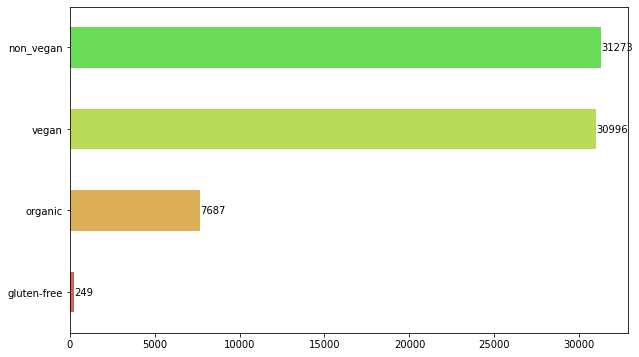

In [ ]:
# Top 4 Labels used in foods
plt.figure(figsize=(10,6))
label_count = data["New Label"].value_counts()[:4].sort_values()
lplot = label_count.plot.barh(color = sns.color_palette('hls',10))
for i,v in enumerate(label_count):
  lplot.text(v,i, str(v), va='center')
# plt.xlim(xmax=12500)
plt.show()

**Comment:** Most of the food products in this database are Organic, which means the foods being recommended for the users are *grown on soil that had no prohibited substances applied for three years prior to harvest*, and are considered safe and healthy. 

For recommendation purpose, only the popular and common choices of labels are chosen including:

- Organic
- Non_Vegan
- Vegan


In [ ]:
df = data[data["New Label"].isin(["vegan","organic","non_vegan"])]
len(df)

69956

In [ ]:
# df.index = range(len(df))
df.head(20)

,Name,url,Ingredients,Category,Label,Countries,nutri_grade,nova_grade,New Category,New Label,New Ingredients,Combination
0,Romaine Hearts,http://world-en.openfoodfacts.org/product/0000651003214/romaine-hearts-ocean-mist-farms,Romaine hearts.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine-hearts,vegan vegetables romaine-hearts
1,Romaine lettuce,http://world-en.openfoodfacts.org/product/0000651041001/romaine-lettuce-ocean-mist-farms,Romaine.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,romaine,vegan vegetables romaine
2,Green Leaf Lettuce,http://world-en.openfoodfacts.org/product/0000651041025/green-leaf-lettuce-ocean-mist-farms,Green leaf.,vegetables,Vegan,United States,a,3.0,vegetables,vegan,green-leaf,vegan vegetables green-leaf
3,Cooking Spinach,http://world-en.openfoodfacts.org/product/0000651213026/cooking-spinach-ocean-mist,Cooking spinach,vegetables,Vegan,United States,a,3.0,vegetables,vegan,cooking-spinach,vegan vegetables cooking-spinach
4,Fuji pom blend juice,http://world-en.openfoodfacts.org/product/0000764001770/fuji-pom-blend-juice-ryan-orchards,"Fuji apple cider, apple cider, pomegranate juice.",plant-based beverages,Vegan,United States,e,1.0,plant-based-beverages,vegan,fuji-apple-cider apple-cider pomegranate-juice,vegan plant-based-beverages fuji-apple-cider apple-cider pomegranate-juice
5,"Ryan's, Organic Juice, Apple",http://world-en.openfoodfacts.org/product/0000764114944/ryan-s-organic-juice-apple-ryan-orchards,100% organic apple juice.,plant-based beverages,Vegan,United States,c,1.0,plant-based-beverages,vegan,organic-apple-juice,vegan plant-based-beverages organic-apple-juice
6,Raw Shrimp,http://world-en.openfoodfacts.org/product/0000850600108/raw-shrimp-maxfield,"Shrimp salt, sodium phosphate (to retain moisture)",seafood,Non Vegan,United States,b,1.0,seafood,non_vegan,shrimp-salt sodium-phosphate,non_vegan seafood shrimp-salt sodium-phosphate
7,"Guiltless Gourmet, Organic Unsweetened Coconut Water",http://world-en.openfoodfacts.org/product/0000901005005/guiltless-gourmet-organic-unsweetened-coconut-water-guiltless-gourmet-inc,"Organic coconut water, ascorbic acid.",plant-based beverages,Vegan,United States,c,1.0,plant-based-beverages,vegan,organic-coconut-water ascorbic-acid,vegan plant-based-beverages organic-coconut-water ascorbic-acid
8,Dehydrated potato dices,http://world-en.openfoodfacts.org/product/0000946111105/dehydrated-potato-dices,Dehydrated potatoes.,vegetables,Vegan,United States,a,1.0,vegetables,vegan,dehydrated-potatoes,vegan vegetables dehydrated-potatoes
9,Dehydrated potato flakes,http://world-en.openfoodfacts.org/product/0000946111136/dehydrated-potato-flakes,"Potatoes, monoglycerides, sodium acid pyrophosphate, citric acid. freshness preserved with sodium bisulfite and bha.",vegetables,Vegan,United States,a,4.0,vegetables,vegan,potatoes monoglycerides sodium-acid-pyrophosphate citric-acid-freshness-preserved-with-sodium-bisulfitebha,vegan vegetables potatoes monoglycerides sodium-acid-pyrophosphate citric-acid-freshness-preserved-with-sodium-bisulfitebha


####Category

Which **Categories** are the most common among the products?

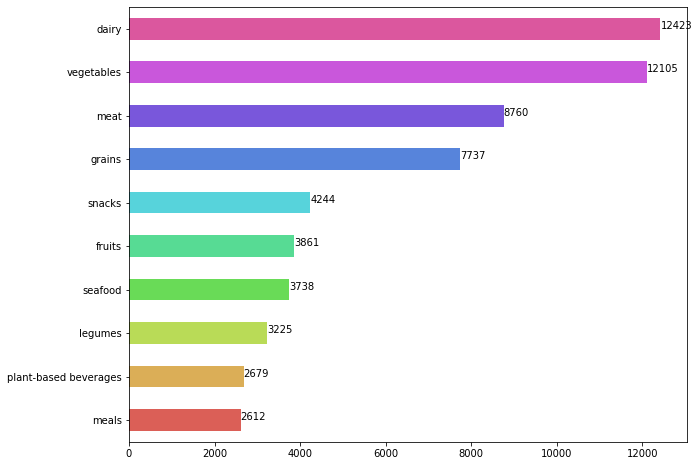

In [ ]:
# Top 10 categories
plt.figure(figsize=(10,8))
cat_count = df.Category.value_counts()[:10].sort_values()
cplot = cat_count.plot.barh(color = sns.color_palette('hls',10))
for i,v in enumerate(cat_count):
  cplot.text(v,i, str(v))
plt.show()

####Nova-grade & Nutri-grade

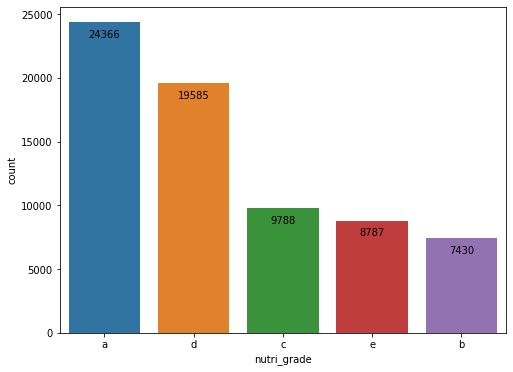

In [ ]:
nutri_count = df['nutri_grade'].value_counts().reset_index()
nutri_count = nutri_count.rename(columns={'index':'nutri_grade','nutri_grade':'count'})
nutri_count.sort_values('count',ascending=False,inplace=True)

plt.figure(figsize=(8,6))
plt.subplot()
nplot = sns.barplot(data=nutri_count, x='nutri_grade',y='count',order=nutri_count['nutri_grade'].values)

for p in nplot.patches:
  nplot.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va='center',
                 xytext=(0,-12),
                textcoords = 'offset points')
plt.show()

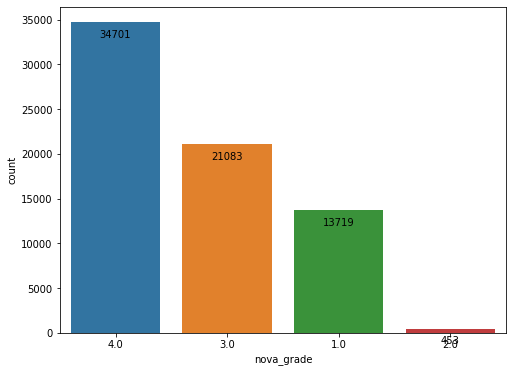

In [ ]:
nova_count = df['nova_grade'].value_counts().reset_index()
nova_count = nova_count.rename(columns={'index':'nova_grade','nova_grade':'count'})
nova_count.sort_values('count',ascending=False,inplace=True)

plt.figure(figsize=(8,6))
plt.subplot()
nplot = sns.barplot(data=nova_count, x='nova_grade',y='count',order=nova_count['nova_grade'].values)

for p in nplot.patches:
  nplot.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va='center',
                 xytext=(0,-12),
                textcoords = 'offset points')
plt.show()

##Combine columns for TF-IDF

In [ ]:
df["Combination"] = df["New Label"] + " " + df["New Category"] + " " + df["New Ingredients"]
final_df = df.drop(columns=["New Label", "New Category", "New Ingredients","Countries","url"])
final_df.head(3)

,Name,Ingredients,Category,Label,nutri_grade,nova_grade,Combination
0,Romaine Hearts,Romaine hearts.,vegetables,Vegan,a,3.0,vegan vegetables romaine-hearts
1,Romaine lettuce,Romaine.,vegetables,Vegan,a,3.0,vegan vegetables romaine
2,Green Leaf Lettuce,Green leaf.,vegetables,Vegan,a,3.0,vegan vegetables green-leaf


#Export file

In [ ]:
final_df = final_df[~final_df.Name.duplicated()]
len(final_df)

48782

In [ ]:
final_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/recommendation_df.csv", index=False)

#Food-based Recommendation

In [ ]:
def food_based_recommender(name):

  rec_df = final_df.drop(columns=["Combination"])

  tfidf_vect = TfidfVectorizer(min_df=2, stop_words=stopwords_nltk)
  tfidf_matrix = tfidf_vect.fit_transform(final_df["Combination"])

    #Compute similarities
  cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
  indices = pd.Series(rec_df.index, index=rec_df['Name'])

  idx = indices[name]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key= lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  ndx = [i[0] for i in sim_scores]
  return rec_df[["Name","url","Category","Label","Nutri_grade","Nova_grade"]].iloc[ndx]

In [ ]:
food_based_recommender("Ryan's, Organic Juice, Apple")

,Name,url,Category,Label,Nutri_grade,Nova_grade
5529,Organic unfiltered apple juice,http://world-en.openfoodfacts.org/product/0079893403564/organic-unfiltered-apple-juice,plant-based beverages,organic,c,1.0
9432,Cold-Pressed High Pressure Processed Organic,http://world-en.openfoodfacts.org/product/0762357059611/cold-pressed-high-pressure-processed-organic-evolution-fresh,plant-based beverages,organic,e,1.0
947,Kids organic apple juice drink,http://world-en.openfoodfacts.org/product/0022014640003/kids-organic-apple-juice-drink,plant-based beverages,organic,d,1.0
9977,100% Organic Lemon Juice,http://world-en.openfoodfacts.org/product/0810533009865/100-organic-lemon-juice,plant-based beverages,organic,d,1.0
2920,Apple juice from organic concentrate,http://world-en.openfoodfacts.org/product/0049000070170/apple-juice-from-organic-concentrate-hansens,plant-based beverages,organic,e,1.0
11999,Organic juice,http://world-en.openfoodfacts.org/product/0858748002318/organic-juice-wacky-apple-company-inc,plant-based beverages,organic,e,1.0
11212,"Blueprint, Grass Monkey, Organic Vegetable & Fruit Drink Blend, Kale, Banana, Spinach, Romaine, Apple, Parsley",http://world-en.openfoodfacts.org/product/0852043003285/blueprint-grass-monkey-organic-vegetable-fruit-drink-blend-kale-banana-spinach-romaine-apple-parsley-the-hain-celestial-group-inc,plant-based beverages,organic,e,1.0
11217,Organic Vegetable & Fruit Drink Blend,http://world-en.openfoodfacts.org/product/0852043003582/organic-vegetable-fruit-drink-blend-the-hain-celestial-group-inc,plant-based beverages,organic,e,1.0
9292,"Columbia gorge organic, organic apple cider",http://world-en.openfoodfacts.org/product/0748753111122/columbia-gorge-organic-organic-apple-cider,beverages,organic,e,2.0
9806,Organic apple nectar,http://world-en.openfoodfacts.org/product/0799210375045/organic-apple-nectar,plant-based beverages,organic,e,1.0


In [ ]:
food_based_recommender("Beef Bologna")

,Name,Ingredients,Category,Label,Nutri_grade,Nova_grade
4562,12 Oz,"beef, water, ccntains 2% or less of: salt, spice, sodium, lactate, paprika, hydrolyzed soy protein, garlic powder, sodium diactate, sodium erythorbate, flavoring, sodium nitrite,",meat,gluten-free,e,4.0
2932,"Hardwood smoked hickory sliced ham with natural juices, sliced ham","Pork, water, contains less than 2% of salt, sodium citrate, sodium phosphate, brown sugar, sodium diacetate, sodium erythorbate, sodium nitrite.",hams,gluten-free,c,3.0
3765,Dice Ham,"Cured with water, dextrose, salt, modified food starch, potassium lactate, sodium phosphates, sodium diacetate, sodium erythorbate, sodium nitrite.",diced ham,gluten-free,d,4.0
3950,"Kunzler, Organic Sliced Bacon","Cured with: water, salt, sugar, sodium phosphates, sodium erythorbate, natural flavorings, sodium nitrite.",sliced bacon,organic,e,4.0
2315,Honey Maple Turkey Breast With Caramel,"Turkey breast meat, turkey broth, honey, contains 2% or less maple syrup, salt, sugar, sodium phosphate, maple flavor (vanilla extract, water, sugar syrup, maple extract, natural flavor), sodium acetate, sodium diacetate, sodium nitrite, sodium erythorbate, caramel color. no gluten.",meat,gluten-free,c,4.0
4218,Beef sausage bites,"Beef, salt, contains 2% or less of: corn syrup solids, natural spices, dextrose, lactic acid starter culture, natural flavorings, sodium erythorbate (made from sugar), garlic powder, sodium nitrite, water. gluten free.",snacks,gluten-free,e,4.0
2747,Ultra thin deli select honey ham,"Cured with water, honey, contains 2% or less: salt, dextrose, sugar, sodium phosphate, sodium propionate, sodium erythorbate, sodium nitrite,",hams,low-fat,d,4.0
4208,Maple turkey breast,"TURKEY, TURKEY BROTH, SALT, BROWN SUGAR, POTASSIUM ACETATE, SODIUM PHOSPHATES, POTASSIUM LACTATE, SODIUM ERYTHORBATE, SODIUM NITRITE",turkeys,gluten-free,c,3.0
4207,Italian Dry Salame,"Pork, salt, nonfat dry milk, sugar, corn syrup, spices, wine, garlic, lactic acid starter culture, sodium nitrite, sodium nitrate.",meat,gluten-free,e,3.0
1706,"Hormel, cure 81, diced boneless ham","Water, salt, sugar, sodium phosphates, natural flavor, lactic acid starter culture (not from milk).",meat,gluten-free,d,4.0


#Criteria-based Recommendation

In [ ]:
feat_df = final_df.drop(columns=['Combination'])

##Predict Nova & Nutri grade

In [ ]:
def nutri_grade_convert(nutri_score):
  """ 
  Function to convert Nutri-score to Nutri-grade
  """

  if nutri_score >= -15 and nutri_score <= -1:
    nutri_grade = "a"
  elif nutri_score >=0 and nutri_score <=2:
    nutri_grade = "b"
  elif nutri_score >=3 and nutri_score <= 10:
    nutri_grade = "c"
  elif nutri_score >=11 and nutri_score <=18:
    nutri_grade = "d"
  else:
    nutri_grade = "e"

  return nutri_grade

In [ ]:
def insert_nutrients():
  """
  Function for user to insert the nutrition information
  then get the Nutri-grade and Nova-grade prediction
  """

  input_df = pd.DataFrame(columns=["Cholesterol","Fat", "Fiber", "Saturated fat", "Carbohydrates", "Protein", "Sodium", "Sugars", "Energy_kcal", "Additives"])

  ### Inputing ###
  print("What is the Serving size?")
  serv = float(input())

  print("Cholesterol: ")
  chol = float(input())/serv*100
  print("Fat: ")
  fat = float(input())/serv*100
  print("Fiber: ")
  fiber = float(input())/serv*100
  print("Trans fat: ")
  trans = float(input())/serv*100/serv*100
  print("Saturated fat: ")
  sat = float(input())/serv*100
  print("Carbohydrate: ")
  carb = float(input())/serv*100
  print("Protein: ")
  pro = float(input())/serv*100
  print("Sodium: ")
  sodium = float(input())/serv*100
  print("Sugars: ")
  sug = float(input())/serv*100
  print("Energy (kcal): ")
  ener = float(input())/serv*100
  print("Additives: ")      
  add = float(input())

  input_df.loc[0] = [chol, fat, fiber, sat, carb, pro, sodium, sug, ener, add]
  return input_df

In [ ]:
input_df = pd.DataFrame(columns=["Cholesterol","Fat", "Fiber", "Trans fat", "Saturated fat", "Carbohydrates", "Protein", "Sodium", "Sugars", "Energy_kcal", "Additives"])
input_df.loc[0] = [0, 11.1, 15, 0, 1.1, 51.3, 13.1, 0.0018, 1.8, 354, 0]
input_df

,Cholesterol,Fat,Fiber,Trans fat,Saturated fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives
0,0.0,11.1,15.0,0.0,1.1,51.3,13.1,0.0018,1.8,354.0,0.0


In [ ]:
#Oatmeal
nutri_rfr = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Old_files/best_nutri_rfr_old.pkl")
nutri_score_pred = nutri_rfr.predict(input_df)
nutri_grade = nutri_grade_convert(nutri_score_pred)
nutri_grade

'a'

In [ ]:
#Oatmeal
nova_rfc = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_rfc_11.pkl")
nova_grade= nova_rfc.predict(input_df)
nova_grade

array([1.])

In [ ]:
#Oatly
input_df.loc[0] = [0, 5/240, 3/240, 0, 0.5/240, 16/240, 3/240, 0.1/240, 7/240, 120/240, 4]
nutri_score_pred = nutri_rfr.predict(input_df)
nutri_grade = nutri_grade_convert(nutri_score_pred)
nutri_grade

'b'

In [ ]:
nova_grade= nova_rfc.predict(input_df)
nova_grade

array([4.])

In [ ]:
def make_prediction():
  """
  Function to predict Nutri-score and classify Nova-grade
  """

  ### Get input from user ###
  input_df = insert_nutrients()

  ### Load pre-built ML pipelines ###)
  nova_rfc = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/best_nova_rfc.pkl")
  nutri_rfr = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/best_nutri_rfr.pkl")

  ### Predict Nutri-score & Classify Nutri-grade ###
  nutri_score_pred = nutri_rfr.predict(input_df)
  nutri_grade = nutri_grade_convert(nutri_score_pred)

  ### Predict Nova-grade ###
  nova_grade_pred = nova_rfc.predict(input_df)

  print(f"Your food Nutri-grade: {nutri_grade} \nNOVA-grade {nova_grade_pred})

In [ ]:
make_prediction()

What is the Serving size?
100
Cholesterol: 
0
Fat: 
11
Fiber: 
15
Trans fat: 
0
Saturated fat: 
1
Carbohydrate: 
51
Protein: 
13
Sodium: 
0.0018
Sugars: 
1.8
Energy (kcal): 
354
Additives: 
0

You should have this more often!
 It's both Nutritious and Minimally Processed


##Recommendations

In [ ]:
stopwords_nltk = stopwords.words("english")
new_stopwords = ['filtered','including','every','actual','equivalent', 'less','contains','actual',"concentrate","100","artificial","coloring","simple","medium","chain","flavorings","flavor",""]
stopwords_nltk.extend(new_stopwords)

In [ ]:
def ask_questions(df):

  # Ask for Nutrition grade
  print("Are nutritions important to you? (Y/N)")
  nutri = input()
  if nutri == "y":
    df_nutri = df[df["nutri_grade"]== "a"]
  else:
    df_nutri = df

  # Ask for Nova grade
  print("Do you prefer non-processed foods only? (Y/N)")
  nova = input()
  if nova == "y":
    df_nova = df_nutri[df_nutri["nova_grade"]==1.0]
  else:
    df_nova = df_nutri

  # Ask for Label:
  print("Are you Vegan? (Y/N)")
  label = input()
  if label == "y" or label == "Y":
    df_label = df_nova[df_nova["Label"] == "Vegan"]
  elif label =="n" or label =="N":
    df_label = df_nova[df_nova["Label"] != "Vegan"]

  # Ask for Category:
  print("Which Category are you looking for? (snacks, foods, etc.)")
  cat = input()
  df_cat = df_label[df_label["Category"].str.contains(cat, flags=re.IGNORECASE, regex=True)]

  return df_cat

In [ ]:
feat_df

,Name,url,Ingredients,Category,Label,Countries,nutri_grade,nova_grade
0,Romaine Hearts,http://world-en.openfoodfacts.org/product/0000651003214/romaine-hearts-ocean-mist-farms,Romaine hearts.,vegetables,Vegan,United States,a,3.0
1,Romaine lettuce,http://world-en.openfoodfacts.org/product/0000651041001/romaine-lettuce-ocean-mist-farms,Romaine.,vegetables,Vegan,United States,a,3.0
2,Green Leaf Lettuce,http://world-en.openfoodfacts.org/product/0000651041025/green-leaf-lettuce-ocean-mist-farms,Green leaf.,vegetables,Vegan,United States,a,3.0
3,Cooking Spinach,http://world-en.openfoodfacts.org/product/0000651213026/cooking-spinach-ocean-mist,Cooking spinach,vegetables,Vegan,United States,a,3.0
4,Fuji pom blend juice,http://world-en.openfoodfacts.org/product/0000764001770/fuji-pom-blend-juice-ryan-orchards,"Fuji apple cider, apple cider, pomegranate juice.",plant-based beverages,Vegan,United States,e,1.0
...,...,...,...,...,...,...,...,...
69951,"Ayam brand, sardines in chili oil",http://world-en.openfoodfacts.org/product/9556041600040/ayam-brand-sardines-in-chili-oil,"Fried sardines fish (sardines fish, palm oil), chili oil (soybean oil, dried chili), water, fried garlic (garlic, palm oil), sugar, salt, soy sauce (soybean, wheat, sugar, salt, water), chili",seafood,Non Vegan,United States,e,3.0
69952,"Ayam brand, sardines in kung pao sauce",http://world-en.openfoodfacts.org/product/9556041600057/ayam-brand-sardines-in-kung-pao-sauce,"Fried sardines fish (sardines fish, palm oil), water, soy sauce (soybean, wheat, sugar, salt, water), onion, sugar, garlic, soybean oil, vinegar, dried chili, chili, modified tapioca starch, ginger, salt, guar gum, szechuan pepper.",seafood,Non Vegan,United States,d,4.0
69953,"Ayam brand, mackerel in tomato sauce",http://world-en.openfoodfacts.org/product/9556041600255/ayam-brand-mackerel-in-tomato-sauce,"Mackerel, water, tomato paste, salt, xanthan gum.",seafood,Non Vegan,United States,d,4.0
69954,Baked Beans In Tomato Sauce,http://world-en.openfoodfacts.org/product/9556041602211/baked-beans-in-tomato-sauce-ayam,"Water, us-grown great northern beans, sugar, tomato paste, thickener, salt, vinegar, mixed spices (containing onion & garlic powder)",legumes,Vegan,United States,a,4.0


In [ ]:
def get_ingredients():
  """Function to find user's favorite ingredients"""

  print("What ingredients would You like to have?")
  ing = input()
  return ing

In [ ]:
def compute_similarities():
  """ Function to compute cosine_similarities between the user's preference and the total food products in the dataset """

  ### Get the user's preferences:
  prefer_df = ask_questions(final_df)

  stopwords_nltk = stopwords.words("english")
  new_stopwords = ['filtered','including','every','actual','equivalent', 'less','contains','actual',"concentrate","100","artificial","coloring","simple","medium","chain","flavorings","flavor",""]
  stopwords_nltk.extend(new_stopwords)

  ### Create a tf-idf matrix:
  vectorizer = TfidfVectorizer(min_df=2, stop_words=stopwords_nltk)
  tfidf_matrix = vectorizer.fit_transform(prefer_df["Combination"].values)

  user = get_ingredients()
  user_transformed = vectorizer.transform([user])

  ### Compute similarity and get 10 most similar items
  cs = cosine_similarity(tfidf_matrix, user_transformed)
  sim_idx = list(cs.flatten().argsort()[::-1])[:5]
  # print(sim_idx)
  return prefer_df.drop(columns=["Combination"]).iloc[sim_idx]

In [ ]:
compute_similarities()

Are nutritions important to you? (Y/N)
y
Do you prefer non-processed foods only? (Y/N)
n
Are you Vegan/Gluten-free?
n
Which Category are you looking for? (snacks, foods, etc.)
snacks
What ingredients would You like to have?
banana strawberry


,Name,Ingredients,Category,Label,Nutri_grade,Nova_grade
11176,Noka organic strawberry,"Strawberry*, banana*, apple*, water, brown rice protein*, flax seed*, natural flavors*, pineapple juice concentrate*, lemon juice concentrate*, camu camu*",snacks,organic,a,4.0
7134,"Mango, goldenberry, banana, chia organic fruit bars","Banana (80%)***, goldenberry (10)***, mango (7%)*** and chia (3%).",snacks,organic,a,3.0
11174,Noka organic blueberry / beet maqui berry / banana,"Banana*, blueberry*, apple*, water, beet juice concentrate*, brown rice protein*, flax seed*, lemon juice concentrate*, natural flavors*, maqui berry*",snacks,organic,a,4.0
6023,Organic fruit pouches,"Organic apple puree (organic apples, ascorbic acid), organic banana puree (organic bananas, ascorbic acid), organic blueberry puree, organic lemon juice concentrate, ascorbic acid.",snacks,organic,a,1.0
11784,Organic Chia Prebiotic Strawberry Lemonade,"Hydrated organic chia seeds (water, organic chia seeds), organic strawberry puree organic apple puree, organic white grape juice concentrate, organic jerusalem artichoke powder, organic natural flavors, organic lemon juice concentrate, fruit and vegetable juice for color, citric acid.",snacks,organic,a,4.0


In [ ]:
feat_df.Category.value_counts().head(15)

snacks                   2712
meals                    1316
plant-based-foods        1150
cereals                   611
milk                      559
pastas                    424
plant-based beverages     403
yogurts                   356
cheese                    344
breads                    321
desserts                  311
canned common beans       258
beverages                 236
dips                      222
confectioneries           215
Name: Category, dtype: int64

#Personalized Recommendation

##TF-IDF Vectorization

In [ ]:
stopwords_nltk = stopwords.words("english")
new_stopwords = ['filtered','including','every','actual','equivalent', 'less','contains','actual',"concentrate","100","artificial","coloring","simple","medium","chain","flavorings","flavor",""]
stopwords_nltk.extend(new_stopwords)

In [ ]:
tfidf_vect = TfidfVectorizer(min_df=2, stop_words=stopwords_nltk)
tfidf_matrix = tfidf_vect.fit_transform(final_df["Combination"])
tfidf_matrix.shape

(69956, 4552)

##Cosine Similarities

###User's input

In [ ]:
rec_df = final_df.drop(columns=["Combination"])

In [ ]:
rec_df.iloc[sim_idx].sort_values()

In [ ]:
user = ["banana chocolate organic vegan"]
user_transformed = tfidf_vect.transform(user)

cs = cosine_similarity(tfidf_matrix, user_transformed)
sim_idx=list(cs.flatten().argsort()[::-1])[:10]
rec_df.iloc[sim_idx].sort_values("nutri_grade")

,Name,url,Ingredients,Category,Label,nutri_grade,nova_grade
41102,Sliced strawberries and bananas,http://world-en.openfoodfacts.org/product/0078742112251/sliced-strawberries-and-bananas,"Organic strawberries, organic banana (citric and ascorbic acid to promote color retention).",fruits,Vegan,a,1.0
66946,Banana Flour,http://world-en.openfoodfacts.org/product/0874093000250/banana-flour-fabi-saa,Banana flour,grains,Vegan,b,1.0
46379,"Chef's choice, banana in syrup",http://world-en.openfoodfacts.org/product/0093856991004/chef-s-choice-banana-in-syrup,"Banana(60%), water, sugar.",fruits,Vegan,b,3.0
66343,Organic banana,http://world-en.openfoodfacts.org/product/0859750003317/organic-banana-mavuno-harvest,Organic dried banana,snacks,Organic,c,1.0
60815,Organic freeze dried chocolate bananas,http://world-en.openfoodfacts.org/product/0812907015113/organic-freeze-dried-chocolate-bananas,"Organic freeze-dried banana slices, organic dark chocolate (organic sugar, organic cacao mass, organic cacao butter, and organic soy lecithin).",snacks,Organic,c,3.0
28735,"Johnvince foods, organic banana chips",http://world-en.openfoodfacts.org/product/0064777814154/johnvince-foods-organic-banana-chips,"Organic banana, coconut oil*, sugar*.",snacks,Organic,d,3.0
28742,Organic banana chips,http://world-en.openfoodfacts.org/product/0064777815359/organic-banana-chips,"Organic banana, organic coconut oil, organic sugar.",snacks,Organic,d,3.0
43054,Organic Banana Chips,http://world-en.openfoodfacts.org/product/0079893410432/organic-banana-chips-o-organics,"Organic banana, organic coconut oil, organic sugar.",snacks,Organic,d,3.0
66971,Organic dark chocolate covered banana bites,http://world-en.openfoodfacts.org/product/0875095000668/organic-dark-chocolate-covered-banana-bites,"Dark chocolate (cacao, whole unrefined cane sugar, cacao butter, vanilla), dried banana",snacks,Organic,e,3.0
24486,Organic monkey munch mix,http://world-en.openfoodfacts.org/product/0042563017484/organic-monkey-munch-mix,"Organic dry roasted salted peanuts (organic peanuts, salt), organic banana chips (organic bananas, organic coconut oil, organic cane sugar), organic dark chocolate chips (organic cane sugar, organic chocolate liquor, organic cocoa butter, soy lecithin [an emulsifier], organic vanilla extract), organic dark chocolate banana chips (organic dark chocolate coating [organic sugar, organic cane sugar, organic chocolate liquor, organic cocoa butter, organic soy lecithin {an emulsifier}, organic van...",snacks,Organic,e,4.0


In [ ]:
user = ["banana chocolate strawberry lemon snacks"]
user_transformed = tfidf_vect.transform(user)

cs = cosine_similarity(tfidf_matrix, user_transformed)
sim_idx=list(cs.flatten().argsort()[::-1])[:10]
rec_df.iloc[sim_idx]

,Name,Ingredients,Category,Label,Nutri_grade,Nova_grade
10251,Strawberry & banana organic fruit puree,"Organic strawberry puree, organic banana puree, organic lemon juice concentrate.",snacks,organic,b,1.0
12323,Organic dark chocolate covered banana bites,"Dark chocolate (cacao, whole unrefined cane sugar, cacao butter, vanilla), dried banana",snacks,organic,e,3.0
12079,Organic banana,Organic dried banana,snacks,organic,c,1.0
10952,"Organic Banana, Strawberry, Mango","Organic banana, organic strawberry, organic mango.",plant-based-foods,organic,a,1.0
10258,"Banana & strawberry organic fruit, super oats & seeds puree","Organic banana puree, organic strawberry puree, organic oats, organic chia, organic quinoa, organic lemon juice concentrate.",snacks,organic,b,1.0
3357,"Johnvince foods, organic banana chips","Organic banana, coconut oil*, sugar*.",snacks,organic,d,3.0
10148,"Orange you glad juice, orange, strawberry, banana","Orange juice, strawberry juice, banana puree",plant-based beverages,organic,e,1.0
604,Organic whole milk kefir cultured milk smoothie,"Organic grade a pasteurized cultured milk, organic cane sugar, organic strawberry flavor, organic banana flavor, vitamin d3.",yogurts,organic,b,4.0
10252,"Peter rabbit organics, pumpkin tree, organic fruit snack, mango, banana and orange","Organic banana, organic mango, organic orange, organic lemon juice concentrate.",snacks,organic,b,1.0
10261,Organic fruit snack,"Organic banana, organic mango, organic orange, organic lemon juice concentrate",snacks,organic,b,1.0


In [ ]:
user = ["coffee chocolate milk"]
user_transformed = tfidf_vect.transform(user)

cs = cosine_similarity(tfidf_matrix, user_transformed)
sim_idx=list(cs.flatten().argsort()[::-1])[:10]
final_df.iloc[sim_idx]

,Name,Ingredients,Label,Category,Nova_grade,Nutri_grade,Combination
7102,"Organic cold brew coffee concentrate, original","Filtered water, organic coffee",Organic,Beverages,1.0,e,organic beverages water organic-coffee
7103,"Organic cold brew coffee concentrate, french roast","Filtered water, organic coffee",Organic,Beverages,1.0,c,organic beverages water organic-coffee
1804,"Amy's, cool scoops, organic coconut milk non-dairy frozen dessert, mocha chocolate chip","(vegan): organic coconut milk, organic agave nectar, organic dark chocolate (organic chocolate liquor, organic cane sugar, organic cocoa butter, organic sunflower lecithin), filtered water, organic coffee, organic vanilla extract, organic coffee extract, sea salt, organic guar gum.",Organic,Frozen desserts,4.0,d,organic frozen-desserts organic-coconut-milk organic-agave-nectar organic-dark-chocolate water organic-coffee organic-vanilla-extract organic-coffee-extract sea-salt organic-guar-gum
8988,Organic cold brew coffee 100% plant based dairy-free frozen dessert,"*coconut milk (water, *coconut, *guar gum), *agave syrup, *coconut cream, *ã¢â€â coffee, *ã¢â€â ground coffee beans, *vanilla extract.",Organic,Frozen desserts,4.0,d,organic frozen-desserts coconut-milk agave-syrup coconut-cream coffee ground-coffee-beans vanilla-extract
6403,Organic cinnamon mocha espresso beans,"Cinnamon* milk chocolate* (evaporated cane sugar*, cocoa butter*, whole milk*, unsweetened chocolate*, soy lecithin* [emulsifier*], vanilla*, cinnamon* roasted coffee beans*, pure food glaze",Organic,Chocolate candies,4.0,e,organic chocolate-candies cinnamon-milk-chocolate-cane-sugar cocoa-butter milk unsweetened-chocolate soy-lecithin vanilla cinnamon-roasted-coffee-beans pure-food-glaze
8631,"Ocho, the organic candy bar, mocha","Organic milk chocolate (organic dried cane syrup, organic cocoa butter, organic whole milk powder, organic chocolate liquor, organic soy lecithin (emulsifier), organic vanilla), organic sugar, organic tapioca, organic milk butter, organic coffee, organic egg whites, and salt.",Organic,Confectioneries,4.0,e,organic confectioneries organic-milk-chocolate organic-vanilla organic-sugar organic-tapioca organic-milk-butter organic-coffee organic-egg-whites salt
6769,Organic milk chocolates,"*milk chocolate (*+sugar, *milk powder, *+cocoa butter, * +chocolate liquor, and *+vanilla extract).",Organic,Chocolate candies,3.0,e,organic chocolate-candies milk-chocolate
6620,"Newman's own, premium organic milk chocolate","Organic milk chocolate (organic sugar, organic cocoa butter*, organic whole milk powder, organic chocolate liquor*, organic soy lecithin [an emulsifier], organic vanilla).",Organic,Chocolate candies,4.0,e,organic chocolate-candies organic-milk-chocolate
3583,Organic Milk Chocolate Bar Pieces,"Organic milk chocolate (organic cane sugar, organic cocoa butter, organic whole milk powder, organic unsweetened chocolate, organic soy lecithin [an emulsifier]).",Organic,Chocolate candies,4.0,e,organic chocolate-candies organic-milk-chocolate
7985,"Rebel Kitchen, Organic Coconut Milk Drink With Coffee","Filtered water, coconut milk* (coconut cream*, water), date nectar*, coffee*.",Organic,Beverages,1.0,e,organic beverages water coconut-milk date-nectar coffee


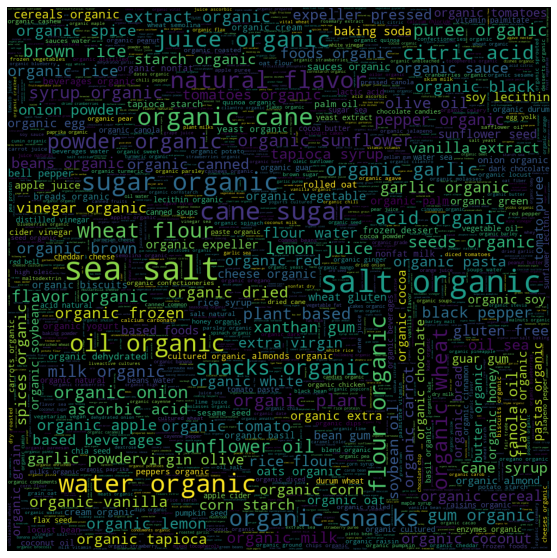

In [ ]:
words = list(df["Bag-of-Words"])
sw = stopwords_nltk.extend("organic")
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords_nltk, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(words))
plt.imshow(wc)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.axis("off")
plt.show()